<a href="https://colab.research.google.com/github/bab81/AI-Algorithms/blob/main/26_Feature_Extraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Pre-trained models

We can choose a pre-trained model based on our application:

Image Classificatation:

*   GoogLeNet(2015)
*   VGGNet
*   ResNet

Text Classification:

*   BERT
*   RoBERTa 



#CLIP: Connecting Text and Images

https://openai.com/blog/clip/

https://github.com/openai/CLIP

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
!pip install git+https://github.com/openai/CLIP.git
import clip
import torch

from sklearn.metrics  import classification_report,confusion_matrix,ConfusionMatrixDisplay

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-vlx3xzrj
  Running command git clone -q https://github.com/openai/CLIP.git /tmp/pip-req-build-vlx3xzrj


In [ ]:
clip.available_models()

['RN50',
 'RN101',
 'RN50x4',
 'RN50x16',
 'RN50x64',
 'ViT-B/32',
 'ViT-B/16',
 'ViT-L/14',
 'ViT-L/14@336px']

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
device

'cuda'

In [ ]:
model, preprocess = clip.load('ViT-B/32', device=device)

In [ ]:
image = preprocess(Image.open("dog.jpeg")).unsqueeze(0).to(device)
text = clip.tokenize(["a diagram", "a dog", "a cat"]).to(device)

In [ ]:
image.shape

torch.Size([1, 3, 224, 224])

In [ ]:
text.shape

torch.Size([3, 77])

In [ ]:
with torch.no_grad():
    image_features = model.encode_image(image.to(device))
    text_features = model.encode_text(text)
    
    logits_per_image, logits_per_text = model(image, text)
    probs = logits_per_image.softmax(dim=-1).cpu().numpy()

In [ ]:
probs

array([[0.001693, 0.9937  , 0.00482 ]], dtype=float16)

##MNIST

In [ ]:
from keras.datasets import mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [ ]:
x_test[0].shape

(28, 28)

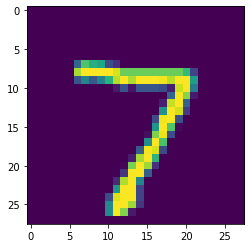

In [ ]:
plt.imshow(x_test[0])

In [ ]:
image = preprocess(Image.fromarray(x_test[0])).unsqueeze(0).to(device)
text = clip.tokenize(["zero","one","two","three","four","five","six","seven","eight",'nine']).to(device)

In [ ]:
with torch.no_grad():
    image_features = model.encode_image(image)
    text_features = model.encode_text(text)
    
    logits_per_image, logits_per_text = model(image, text)
    probs = logits_per_image.softmax(dim=-1).cpu().numpy()

In [ ]:
probs

array([[0.001968, 0.0043  , 0.1199  , 0.0837  , 0.06216 , 0.1857  ,
        0.0338  , 0.4453  , 0.04077 , 0.02252 ]], dtype=float16)

In [ ]:
np.argmax(probs)

7

#CIFAR10

https://www.cs.toronto.edu/~kriz/cifar.html

In [ ]:
from keras.datasets import cifar10, cifar100
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [ ]:
np.unique(y_train)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [ ]:
x_train.shape

(50000, 32, 32, 3)

In [ ]:
x_test.shape

(10000, 32, 32, 3)

[9]


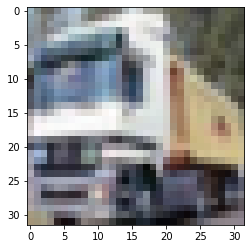

In [ ]:
print(y_train[1])
plt.imshow(x_train[1])

###CIFAR - PCA

(0.0, 20.0)

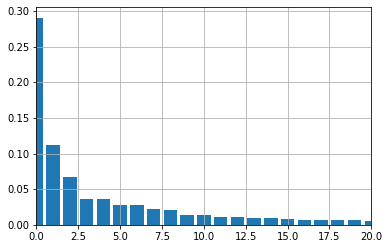

In [ ]:
Model_CIFAR_PCA = PCA()
Model_CIFAR_PCA.fit(x_train.reshape(50000,32*32*3))
x_train_PCA = Model_CIFAR_PCA.transform(x_train.reshape(50000,32*32*3))
x_test_PCA = Model_CIFAR_PCA.transform(x_test.reshape(10000,32*32*3))

plt.bar([i for i in range(len(Model_CIFAR_PCA.explained_variance_ratio_))],Model_CIFAR_PCA.explained_variance_ratio_)
plt.grid()
plt.xlim([0,20])

In [ ]:
sum(Model_CIFAR_PCA.explained_variance_ratio_[:100])

0.9010623230457743

In [ ]:
Number_Features=100

Model_CIFAR_PCA_Linear=LogisticRegression(max_iter=1000,solver='liblinear')
Model_CIFAR_PCA_Linear.fit(x_train_PCA[:,0:Number_Features],y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(max_iter=1000, solver='liblinear')

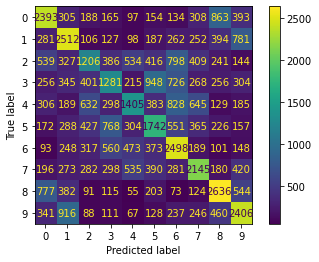

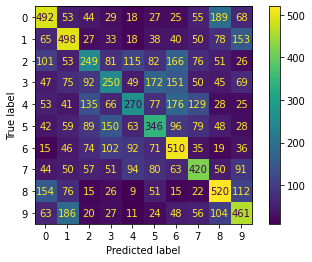

In [ ]:
ConfusionMatrixDisplay(confusion_matrix(y_train,Model_CIFAR_PCA_Linear.predict(x_train_PCA[:,0:Number_Features]))).plot()
ConfusionMatrixDisplay(confusion_matrix(y_test,Model_CIFAR_PCA_Linear.predict(x_test_PCA[:,0:Number_Features]))).plot()

##CIFAR-CLIP

In [ ]:
x_train_CLIP_features=[]
with torch.no_grad():
  for pic in x_train:
    image = preprocess(Image.fromarray(pic)).unsqueeze(0).to(device)
    image_features = model.encode_image(image.to(device))
    x_train_CLIP_features.append(image_features.cpu().numpy()[0])

In [ ]:
x_test_CLIP_features=[]
with torch.no_grad():
  for pic in x_test:
    image = preprocess(Image.fromarray(pic)).unsqueeze(0).to(device)
    image_features = model.encode_image(image.to(device))
    x_test_CLIP_features.append(image_features.cpu().numpy()[0])

In [ ]:
len(x_train_CLIP_features)

50000

In [ ]:
Model_CIFAR_CLIP_Linear=LogisticRegression(max_iter=1000,solver='liblinear')
Model_CIFAR_CLIP_Linear.fit(x_train_CLIP_features,y_train)

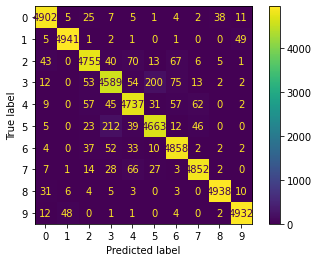

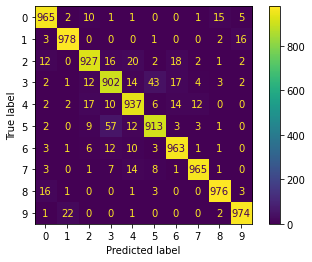

In [ ]:
ConfusionMatrixDisplay(confusion_matrix(y_train,Model_CIFAR_CLIP_Linear.predict(x_train_CLIP_features))).plot()
ConfusionMatrixDisplay(confusion_matrix(y_test,Model_CIFAR_CLIP_Linear.predict(x_test_CLIP_features))).plot()